# **Problem 2: Advanced Histogram-Based Image Enhancement Techniques**

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# A.

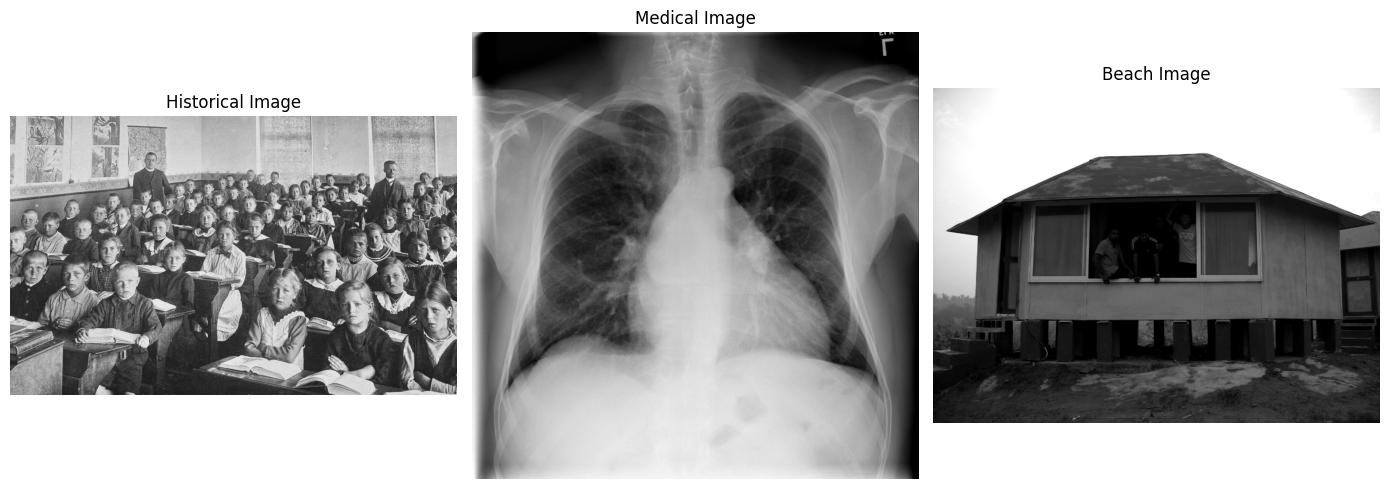

In [2]:
historical_img = cv2.imread('q2_historical.png')
medical_img = cv2.imread('q2_medical.png')
beach_img = cv2.imread('q2_beach.jpg')

# Convert images to Grayscale
historical_img = cv2.cvtColor(historical_img, cv2.COLOR_BGR2GRAY)
medical_img = cv2.cvtColor(medical_img, cv2.COLOR_BGR2GRAY)
beach_img = cv2.cvtColor(beach_img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize= (14, 9))
plt.subplot(1, 3, 1)
plt.imshow(historical_img, cmap = 'gray')
plt.title('Historical Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(medical_img, cmap = 'gray')
plt.title('Medical Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(beach_img, cmap = 'gray')
plt.title('Beach Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# B.

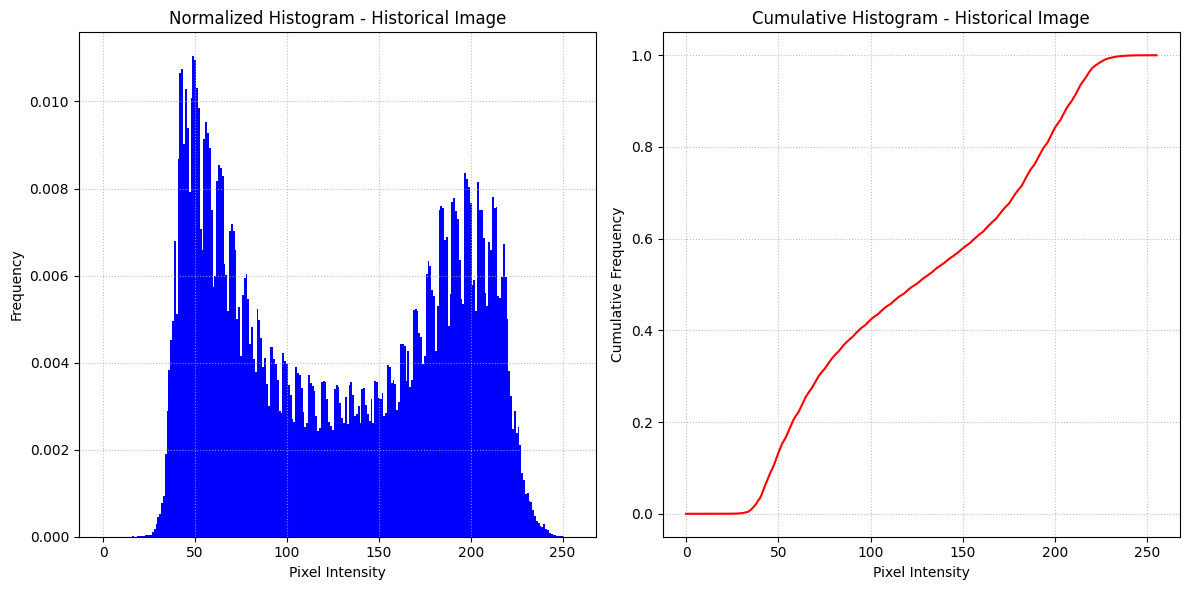

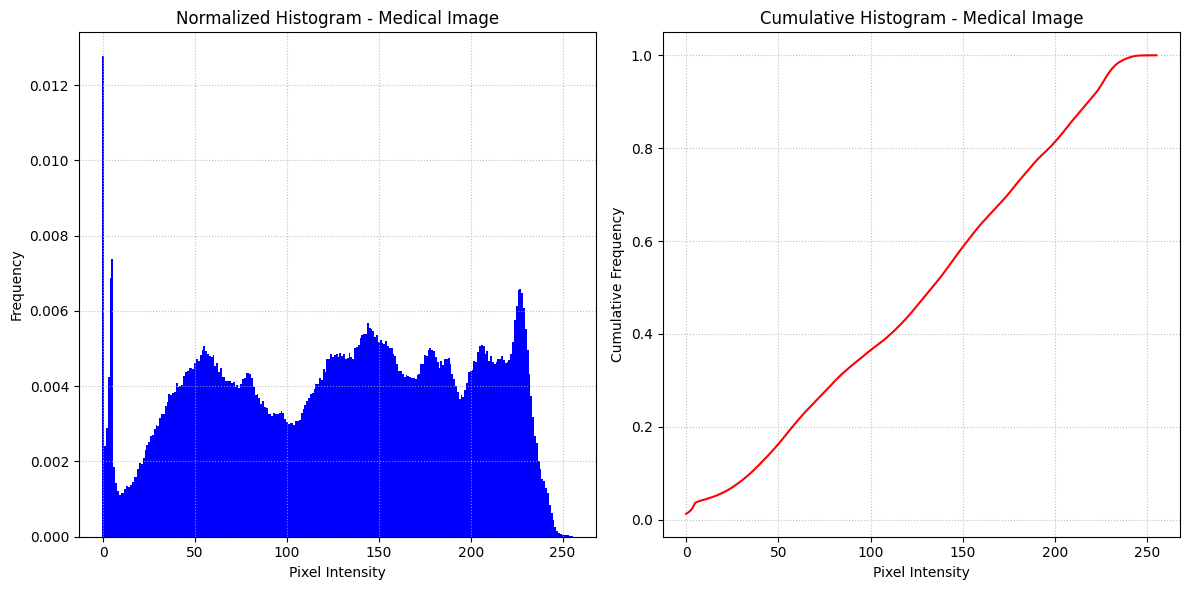

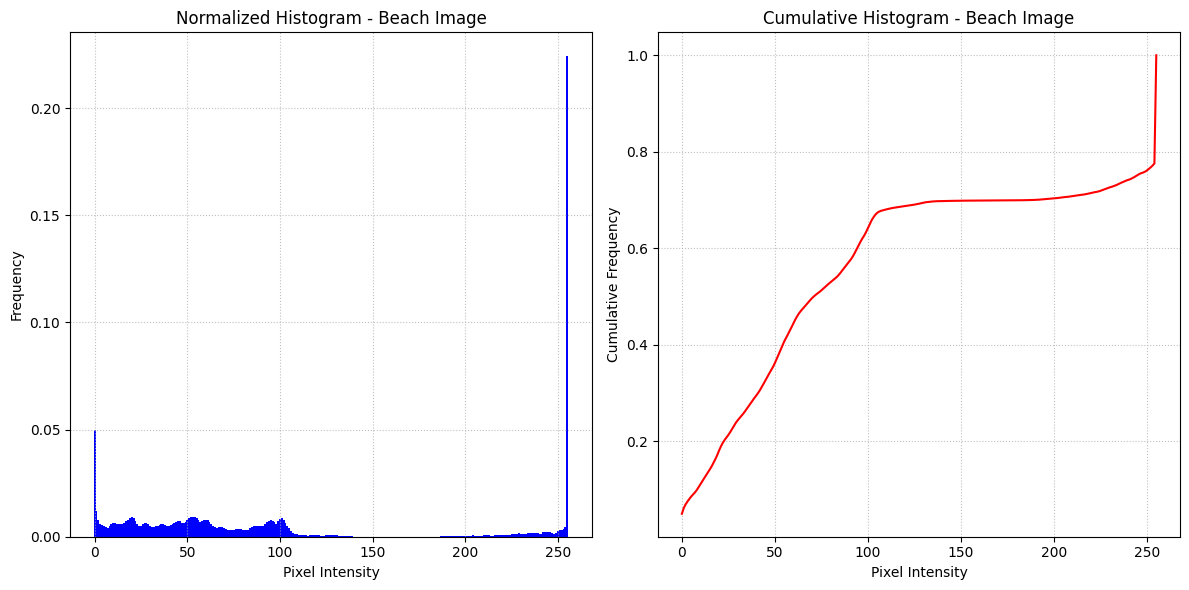

In [3]:
def display_histograms(image, title):
    # Calculate normalized histogram for better comparison between images
    hist_values = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()
    normalized_hist = hist_values / hist_values.sum()   # Normalize histogram to [0, 1]
    # Calculate cumulative histogram
    cumulative_hist = np.cumsum(normalized_hist)
    
    plt.figure(figsize=(12, 6))
    # Show normalized histogram
    plt.subplot(1, 2, 1)
    plt.bar(range(256), normalized_hist, width=1.0, color='blue')
    plt.title(f'Normalized Histogram - {title}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle=':', alpha=0.8)
    
    # Show cumulative histogram
    plt.subplot(1, 2, 2)
    plt.plot(cumulative_hist, color='red')
    plt.title(f'Cumulative Histogram - {title}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Cumulative Frequency')
    plt.grid(True, linestyle=':', alpha=0.8)
    
    plt.tight_layout()
    plt.show()

display_histograms(historical_img, 'Historical Image')
display_histograms(medical_img, 'Medical Image')
display_histograms(beach_img, 'Beach Image')

# C.

 Classical Histogram Equalization (HE):

In [4]:
def he(image):
    # Calculate histogram
    hist_values = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()
    # Calculate cumulative distribution function (CDF)
    cdf = hist_values.cumsum()
    cdf_normalized = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
   
    hist_eq_image = cdf_normalized[image].astype(np.uint8)
    return hist_eq_image

 Bi-Histogram Equalization (BBHE):

In [5]:
def bbhe(image):
    mean_brightness = np.mean(image)
    # Create masks for lower and upper intensity ranges
    lower_mask = image <= mean_brightness
    upper_mask = image > mean_brightness
    
    # Apply HE to masked intensity ranges
    if np.any(lower_mask):
        lower_range = image[lower_mask]
        image[lower_mask] = he(lower_range)
    if np.any(upper_mask):
        upper_range = image[upper_mask]
        image[upper_mask] = he(upper_range)
    
    return image

 Dualistic Sub-Image Histogram Equalization (DSIHE):

In [6]:
def dsihe(image):
    hist_values = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()
    
    # Compute cumulative distribution and find its midpoint
    cdf = hist_values.cumsum()
    cdf_midpoint = cdf[-1] / 2
    threshold = np.argmin(np.abs(cdf - cdf_midpoint))
    
    # Create masks for lower and upper intensity ranges
    lower_mask = image <= threshold
    upper_mask = image > threshold
    
    # Apply HE to masked intensity ranges
    if np.any(lower_mask):
        lower_range = image[lower_mask]
        image[lower_mask] = he(lower_range)
    if np.any(upper_mask):
        upper_range = image[upper_mask]
        image[upper_mask] = he(upper_range)
    
    return image

 Brightness Preserving Dynamic Histogram Equalization (BPDHE):

In [ ]:
def gaussian_smoothing(hist, sigma=1.0):
    # Generate Gaussian kernel over intensity range [0,255]
    x = np.arange(0, 256)
    kernel = np.exp(-(x ** 2) / (2 * sigma ** 2))
    kernel = kernel / kernel.sum()   # Normalize kernel
    smoothed_hist = np.convolve(hist, kernel, mode='same')
    return smoothed_hist

def find_peaks(hist, window_size=5):
    peaks = []
    # Detect local peaks in the histogram
    for i in range(window_size, len(hist) - window_size):
        if hist[i] == max(hist[i - window_size:i + window_size + 1]):
            peaks.append(i)
    return peaks

def bpdeh(image, sigma=1.0, window_size=5):
    hist_values = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()
    # Smooth histogram using Gaussian filter
    smoothed_hist = gaussian_smoothing(hist_values, sigma)
    # Find local peaks
    peaks = find_peaks(smoothed_hist, window_size)
    peaks = [0] + sorted(peaks) + [255]
    
    partitions = []
    # Partition histogram based on peaks
    for i in range(len(peaks) - 1):
        start = peaks[i]
        end = peaks[i + 1]
        partitions.append((start, end))
    
    # Apply HE to each partition
    output = np.zeros_like(image)
    for start, end in partitions:
        mask = (image >= start) & (image <= end)
        partition = image[mask]
        if len(partition) > 0:
            equalized_partition = he(partition)
            output[mask] = equalized_partition
    
    # Normalize output to preserve original mean brightness
    original_mean = np.mean(image)
    output_mean = np.mean(output)
    if output_mean != 0:
        output = (output * original_mean / output_mean).clip(0, 255).astype(np.uint8)
    
    return output

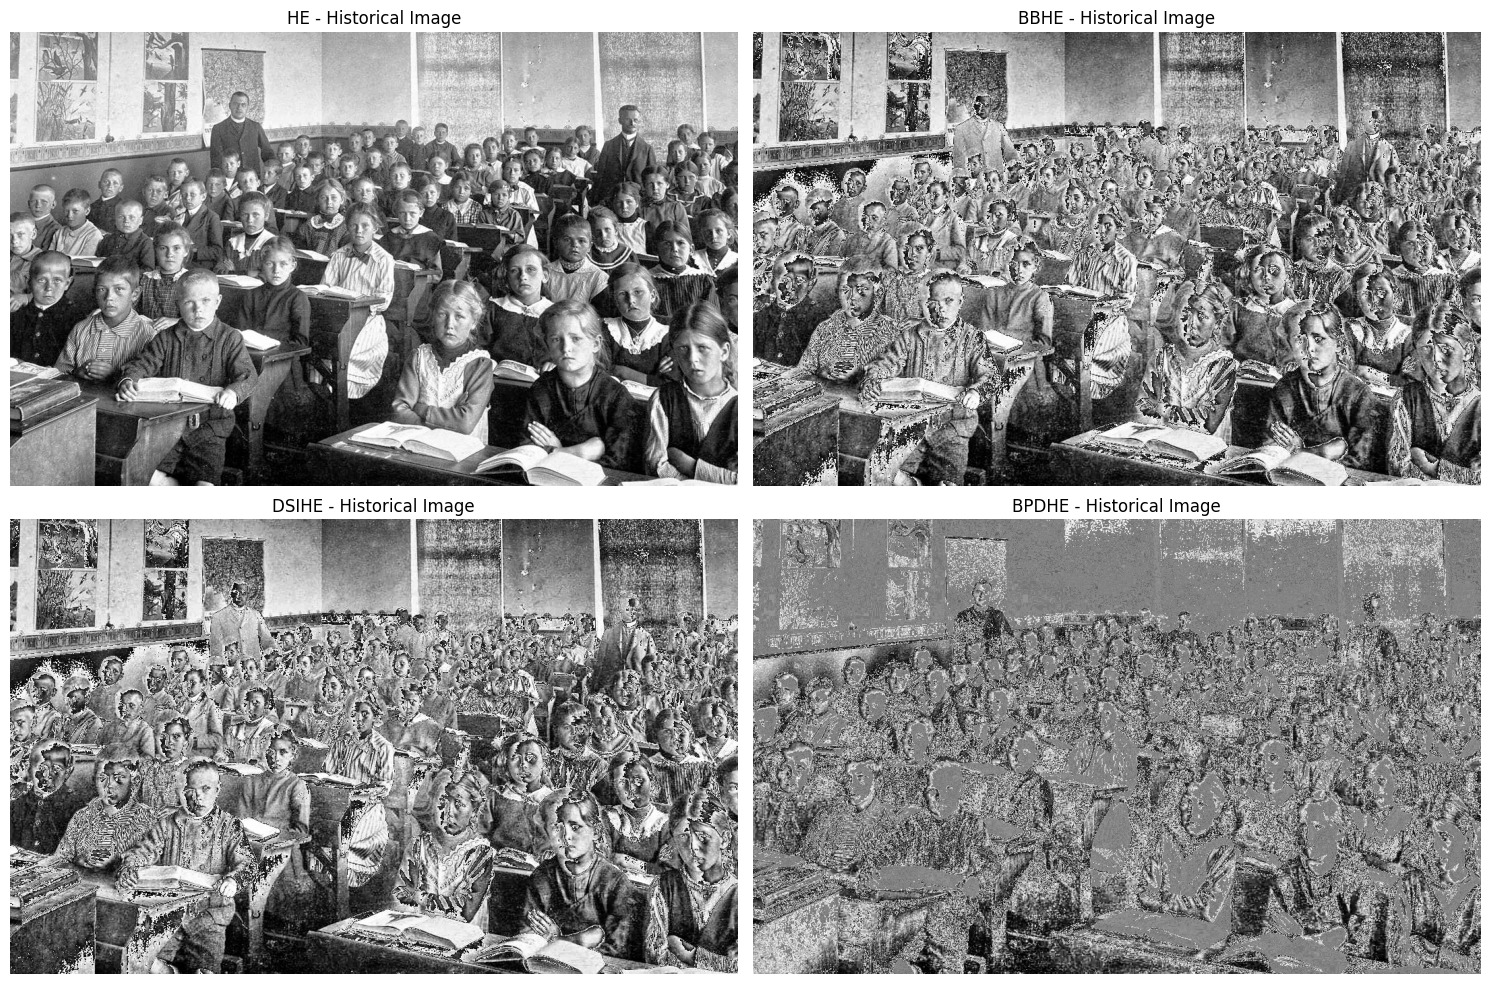

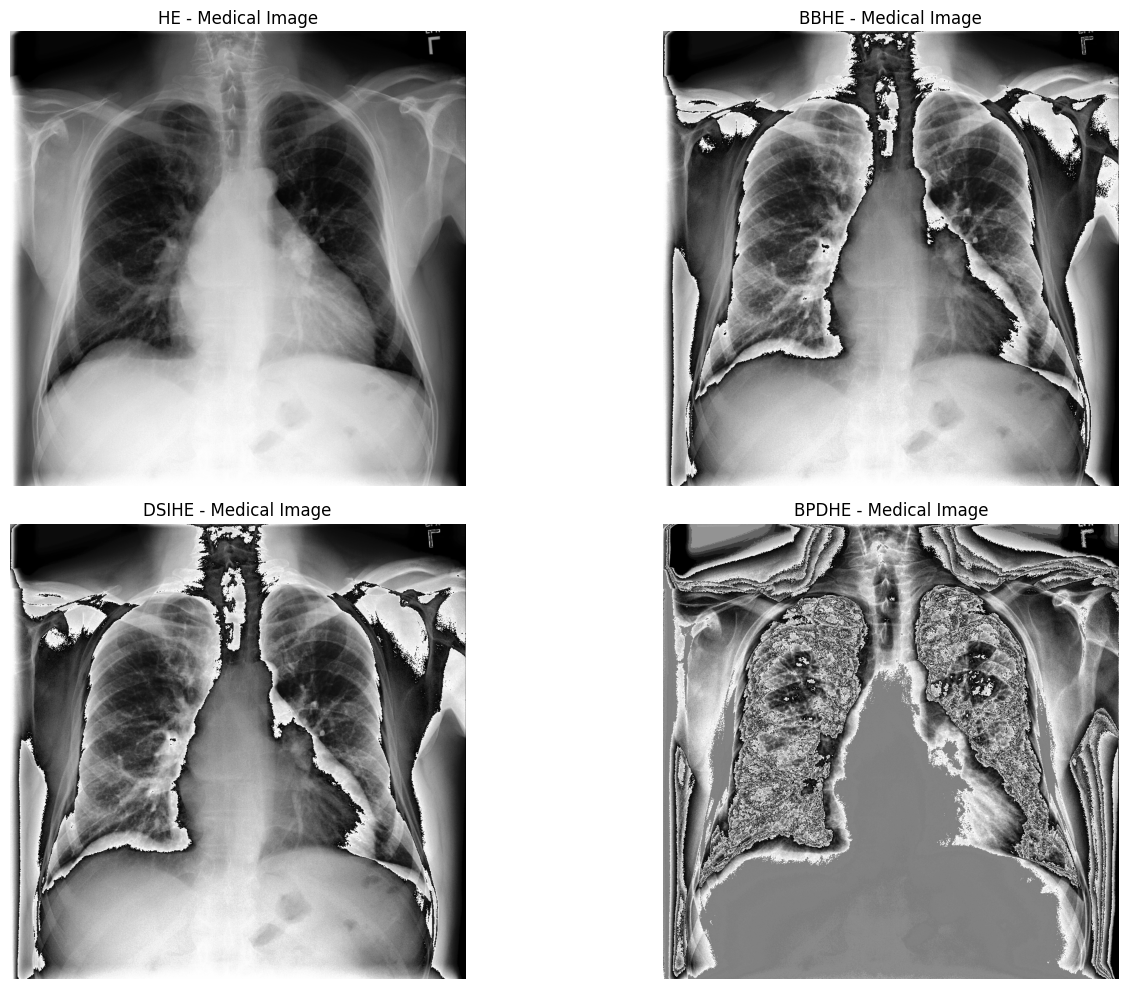

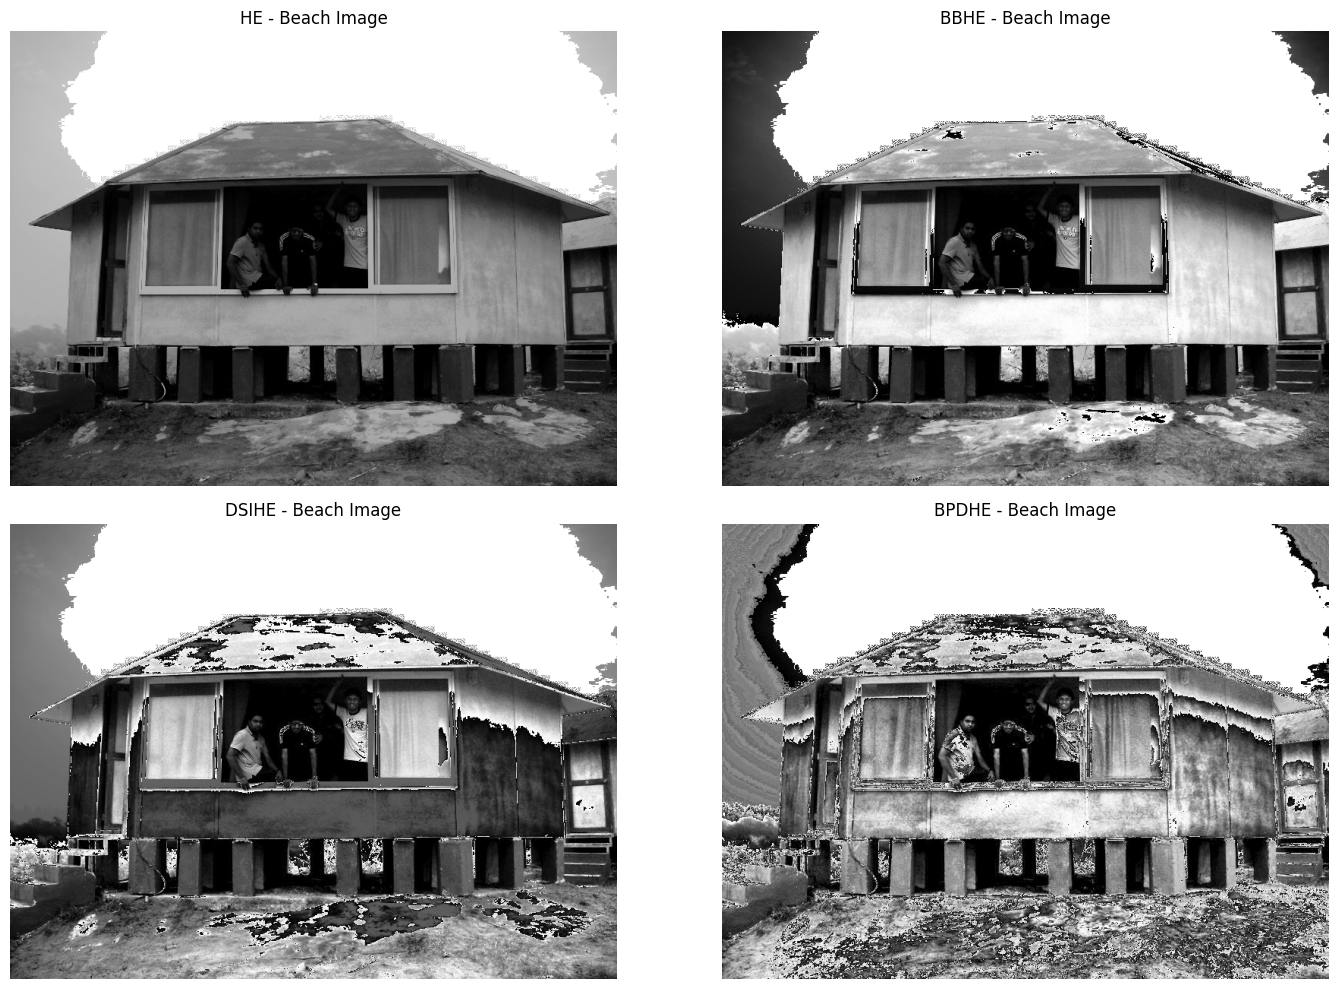

In [8]:
# Show results of all enhancement methods
def show_results(image, title):
    methods = {
        'HE': he,
        'BBHE': bbhe,
        'DSIHE': dsihe,
        'BPDHE': bpdeh
    }
    
    plt.figure(figsize=(15, 10))
    for i, (name, method) in enumerate(methods.items(), 1):
        result = method(image.copy())
        plt.subplot(2, 2, i)
        plt.imshow(result, cmap='gray')
        plt.title(f'{name} - {title}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

show_results(historical_img, 'Historical Image')
show_results(medical_img, 'Medical Image')
show_results(beach_img, 'Beach Image')

PSNR, SSIM and MBS

In [24]:
def method_analysis(original_image):
    methods = {
        'HE': he,
        'BBHE': bbhe,
        'DSIHE': dsihe,
        'BPDHE': bpdeh
    }

    results = []

    for name, method in methods.items():
        enhanced_image = method(original_image.copy())

        # Compute PSNR 
        psnr_val = psnr(original_image, enhanced_image, data_range=255)
        # Compute SSIM 
        ssim_val = ssim(original_image, enhanced_image, data_range=255)
        # Compute MBS 
        original_mean = np.mean(original_image)
        enhanced_mean = np.mean(enhanced_image)
        mbs_val = abs(original_mean - enhanced_mean)

        results.append({
            'Method': name,
            'PSNR': psnr_val,
            'SSIM': ssim_val,
            'MBS': mbs_val
        })

    return results

In [ ]:
pd.set_option('display.float_format', '{:.4f}'.format)   # Set float display

def show_evaluation(results, title):
    df = pd.DataFrame(results)
    print(f"\n{title}")
    print(df.to_string(index=False))

# show results for the historical image
results = method_analysis(historical_img)  
show_evaluation(results, title="Historical Image Evaluation")

# show results for the medical image
results_medical = method_analysis(medical_img)
show_evaluation(results_medical, title="Medical Image Evaluation")

# show results for the beach image
results_beach = method_analysis(beach_img)
show_evaluation(results_beach, title="Beach Image Evaluation")


Historical Image Evaluation
Method    PSNR   SSIM    MBS
    HE 25.1472 0.9050 0.9095
  BBHE 10.6761 0.3464 1.6410
 DSIHE 10.6775 0.3469 1.6650
 BPDHE 10.5619 0.1070 0.4952

Medical Image Evaluation
Method    PSNR   SSIM    MBS
    HE 29.2342 0.9773 2.1893
  BBHE 11.3254 0.6724 1.5999
 DSIHE 11.3567 0.6778 1.6373
 BPDHE  9.9393 0.3770 0.3887

Beach Image Evaluation
Method    PSNR   SSIM     MBS
    HE 17.5394 0.8641 17.8058
  BBHE  9.1937 0.5992 31.6364
 DSIHE  9.9248 0.4962 24.6710
 BPDHE 10.2845 0.3849  0.3965
